In [1]:
import zipfile
import os

def zip_folder(folder_path):
    """
    Zips the contents of a folder and saves it in the same directory.

    Args:
        folder_path (str): Path to the folder to be zipped.
    """
    # Get the folder name and parent directory
    folder_name = os.path.basename(folder_path)
    parent_dir = os.path.dirname(folder_path)

    # Define the zip file path
    zip_file_path = os.path.join(parent_dir, f"{folder_name}.zip")

    # Create a zip file
    with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                # Add file to the zip, preserving folder structure
                arcname = os.path.relpath(file_path, folder_path)
                zipf.write(file_path, arcname)

    print(f"Folder zipped successfully: {zip_file_path}")

# Example usage
folder_to_zip = r"C:\Users\AI-Team\Documents\wind\DATA"
zip_folder(folder_to_zip)

Folder zipped successfully: C:\Users\AI-Team\Documents\wind\DATA.zip


In [ ]:
import zipfile
import os

zip_path = "/content/DATA.zip"
extract_path = "/content"

# Ensure the file exists
if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction complete.")
else:
    print("File not found!")


Extraction complete.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, LSTM, Conv1D, Add, Concatenate, GRU, Flatten,
    RepeatVector, Attention, Dropout, BatchNormalization, Activation
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score




In [2]:
def fix_time_column(df, time_col="Time"):
    """Fix time column format to ensure consistency"""
    if time_col in df.columns:
        df[time_col] = pd.to_datetime(df[time_col], format="%d/%m/%Y %H:%M")
    return df



def prepare_sequence_data(train_df, test_df, target_df, seq_length=2, forecast_horizon=2):
    """
    Prepare sequence data for the Res-ConvLSTM-Attention model.

    Args:
        train_df: DataFrame containing training features
        test_df: DataFrame containing test features
        target_df: DataFrame containing target values for training
        seq_length: Length of input sequences
        forecast_horizon: How far ahead to predict

    Returns:
        X1_train: Historical sequence data for training
        X2_train: Current/forecast data for training
        y_train: Target values for training
        X1_test: Historical sequence data for testing
        X2_test: Current/forecast data for testing
        test_ids: IDs for test predictions
    """
    # Print column names to debug
    print("Columns in train_df:", train_df.columns.tolist())
    print("Columns in test_df:", test_df.columns.tolist())

    # Verify 'WF' column exists
    if 'WF' not in train_df.columns:
        print("ERROR: 'WF' column missing from train_df")
        # Add it if it doesn't exist (use a default value if necessary)
        train_df['WF'] = 'WF1'  # Default value

    if 'WF' not in test_df.columns:
        print("ERROR: 'WF' column missing from test_df")
        # Add it if it doesn't exist
        test_df['WF'] = 'WF1'
    train_with_target = pd.merge(train_df, target_df, on='ID', how='inner')

    # Get list of numeric features (excluding ID, Time, and target)
    # IMPORTANT: Also exclude 'WF' from scaling
    feature_cols = [col for col in train_df.columns
                   if col not in ['ID', 'Time', 'Production', 'WF']]

    # Create a scaler and fit on training data
    scaler = StandardScaler()
    scaler.fit(train_df[feature_cols])

    # Transform both training and test data
    train_scaled = scaler.transform(train_df[feature_cols])
    test_scaled = scaler.transform(test_df[feature_cols])

    # Convert back to DataFrames with original index
    train_scaled_df = pd.DataFrame(train_scaled, columns=feature_cols, index=train_df.index)
    test_scaled_df = pd.DataFrame(test_scaled, columns=feature_cols, index=test_df.index)

    # Add ID, Time, and WF back - IMPORTANT: Make sure WF is added back
    train_scaled_df['ID'] = train_df['ID'].values
    train_scaled_df['Time'] = train_df['Time'].values
    train_scaled_df['WF'] = train_df['WF'].values  # This line is causing the error

    test_scaled_df['ID'] = test_df['ID'].values
    test_scaled_df['Time'] = test_df['Time'].values
    test_scaled_df['WF'] = test_df['WF'].values

    # Add target to training data
    train_with_target_scaled = pd.merge(train_scaled_df, target_df, on='ID', how='inner')

    # Initialize lists to store sequences
    X1_train_sequences = []
    X2_train_values = []
    y_train_values = []
    X1_test_sequences = []
    X2_test_values = []
    test_ids = []

    # Group by wind farm for training data
    for wf, group in train_with_target_scaled.groupby('WF'):
        # Sort by time
        group = group.sort_values('Time')

        # Create sequences for training
        for i in range(len(group) - seq_length - forecast_horizon + 1):
            # Historical sequence (input1)
            X1_seq = group.iloc[i:i+seq_length][feature_cols].values

            # Current/forecast data (input2 - features at the prediction time)
            X2_val = group.iloc[i+seq_length+forecast_horizon-1][feature_cols].values

            # Target value
            y_val = group.iloc[i+seq_length+forecast_horizon-1]['Production']

            X1_train_sequences.append(X1_seq)
            X2_train_values.append(X2_val)
            y_train_values.append(y_val)

    # Group by wind farm for test data
    for wf, group in test_scaled_df.groupby('WF'):
        # Get all training data for this wind farm
        train_wf = train_scaled_df[train_scaled_df['WF'] == wf].sort_values('Time')

        # For each test instance
        for i, row in group.iterrows():
            # Find the closest time points in training data
            # This is a simplified approach - in a real scenario, you'd want to
            # make sure the sequence is consecutive in time
            closest_times = train_wf['Time'].iloc[
                (train_wf['Time'] - row['Time']).abs().argsort()[:seq_length]
            ].sort_values()

            if len(closest_times) == seq_length:
                # Get historical sequence
                history = train_wf[train_wf['Time'].isin(closest_times)].sort_values('Time')
                X1_seq = history[feature_cols].values

                # Current forecast data
                X2_val = row[feature_cols].values

                X1_test_sequences.append(X1_seq)
                X2_test_values.append(X2_val)
                test_ids.append(row['ID'])

    # Convert to numpy arrays with float32 dtype
    X1_train = np.array(X1_train_sequences, dtype=np.float32)
    X2_train = np.array(X2_train_values, dtype=np.float32)
    y_train = np.array(y_train_values, dtype=np.float32)
    X1_test = np.array(X1_test_sequences, dtype=np.float32)
    X2_test = np.array(X2_test_values, dtype=np.float32)

    return X1_train, X2_train, y_train, X1_test, X2_test, test_ids



In [3]:
def calculate_metrics(y_true, y_pred):
    """
    Calculate all requested performance metrics.

    Args:
        y_true: Actual values
        y_pred: Predicted values

    Returns:
        Dictionary of metrics
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Calculate MAAPE (Mean Arctangent Absolute Percentage Error)
    # Handles zero values better than MAPE
    maape = np.mean(np.arctan(np.abs((y_true - y_pred) / (y_true + 1e-10))))

    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAAPE': maape,
        'R2': r2
    }



def visualize_training_history(history):
    """Visualize the training history"""
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Mean Absolute Error')
    plt.legend()
    plt.show()

def visualize_predictions(model, X1_sample, X2_sample, y_sample):
    """Visualize model predictions"""
    # Make predictions
    sample_preds = model.predict([X1_sample, X2_sample])

    plt.figure(figsize=(12, 6))
    plt.scatter(y_sample, sample_preds, alpha=0.5)
    plt.plot([min(y_sample), max(y_sample)], [min(y_sample), max(y_sample)], 'r--')
    plt.xlabel('Actual Production')
    plt.ylabel('Predicted Production')
    plt.title('Actual vs Predicted Wind Power Production')
    plt.show()

In [4]:
def build_res_convlstm_attention_model(input_shape1, input_shape2, output_units=1):
    """
    Build the Res-ConvLSTM-Attention model for wind power forecasting.

    Args:
        input_shape1: Shape of the main input sequence (time steps, features)
        input_shape2: Shape of the secondary input (features)
        output_units: Number of output units (default=1 for power prediction)

    Returns:
        Compiled Keras model
    """
    # Ensure input_shape2 is a tuple
    if isinstance(input_shape2, int):
        input_shape2 = (input_shape2,)

    # Input 1 - Historical sequence data
    input1 = Input(shape=input_shape1, name='input1')

    # Res-ConvLSTM block
    # First ConvLSTM layer
    conv_lstm1 = Conv1D(filters=64, kernel_size=3, padding='same')(input1)
    lstm1 = LSTM(64, return_sequences=True)(conv_lstm1)

    # Second ConvLSTM layer with residual connection
    conv_lstm2 = Conv1D(filters=64, kernel_size=3, padding='same')(lstm1)
    lstm2 = LSTM(64, return_sequences=True)(conv_lstm2)
    res_connection1 = Add()([lstm1, lstm2])

    # Third ConvLSTM layer
    conv_lstm3 = Conv1D(filters=64, kernel_size=3, padding='same')(res_connection1)
    lstm3 = LSTM(64, return_sequences=True)(conv_lstm3)
    res_connection2 = Add()([res_connection1, lstm3])

    # Fourth ConvLSTM layer
    conv_lstm4 = Conv1D(filters=64, kernel_size=3, padding='same')(res_connection2)
    lstm4 = LSTM(64, return_sequences=True)(conv_lstm4)
    res_connection3 = Add()([res_connection2, lstm4])

    # Fifth ConvLSTM layer
    conv_lstm5 = Conv1D(filters=64, kernel_size=3, padding='same')(res_connection3)
    lstm5 = LSTM(64, return_sequences=True)(conv_lstm5)

    # Flatten output
    flattened = Flatten()(lstm5)

    # Input 2 - Current/forecast data
    input2 = Input(shape=input_shape2, name='input2')

    # 1D-CNN for input2
    cnn_input2 = Dense(64)(input2)
    cnn_input2 = BatchNormalization()(cnn_input2)
    cnn_input2 = Activation('relu')(cnn_input2)

    # GRU blocks for sequential processing
    # Repeat vector to match sequence length for attention
    repeat_vector = RepeatVector(input_shape1[0])(cnn_input2)

    # First GRU layer
    gru1 = GRU(64, return_sequences=True)(repeat_vector)

    # Second GRU layer
    gru2 = GRU(64, return_sequences=True)(gru1)

    # Concatenate GRU output with flattened Res-ConvLSTM output
    concat = Concatenate()([gru2, lstm5])

    # Attention mechanism
    attention_layer = Attention()([concat, concat])

    # Final GRU layer
    gru3 = GRU(64)(attention_layer)

    # Fully connected layers
    fc1 = Dense(64, activation='relu')(gru3)
    fc1 = Dropout(0.2)(fc1)

    fc2 = Dense(32, activation='relu')(fc1)
    fc2 = Dropout(0.2)(fc2)

    # Output layer
    output = Dense(output_units, activation='linear')(fc2)

    # Create model
    model = Model(inputs=[input1, input2], outputs=output)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model

def train_forecasting_model(x_train_df, x_test_df, y_train_df, seq_length=2, forecast_horizon=2):
    """
    Train the wind power forecasting model.

    Args:
        x_train_df: Training data with features and metadata
        x_test_df: Test data with features and metadata
        y_train_df: Target values for training
        seq_length: Length of input sequences
        forecast_horizon: How far ahead to predict

    Returns:
        Trained model, test predictions, and training history
    """
    # Prepare sequence data
    X1_train, X2_train, y_train, X1_test, X2_test, test_ids = prepare_sequence_data(
        x_train_df, x_test_df, y_train_df,
        seq_length=seq_length,
        forecast_horizon=forecast_horizon
    )

    # Split into training and validation sets
    X1_train_split, X1_val, X2_train_split, X2_val, y_train_split, y_val = train_test_split(
        X1_train, X2_train, y_train, test_size=0.2, random_state=42
    )

    # Build and compile model
    model = build_res_convlstm_attention_model(
        input_shape1=X1_train_split.shape[1:],  # Shape of historical sequence data
        input_shape2=X2_train_split.shape[1],   # Shape of current/forecast data
    )

    # Define callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint('wind_power_model.h5', save_best_only=True)
    ]

    # Train model
    history = model.fit(
        [X1_train_split, X2_train_split],
        y_train_split,
        validation_data=([X1_val, X2_val], y_val),
        epochs=40,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )
    # Save the model
    model.save('wind_power_forecasting_model.h5')
    print("Model saved as 'wind_power_forecasting_model.h5'")

    # Calculate validation metrics
    val_predictions = model.predict([X1_val, X2_val])
    val_metrics = calculate_metrics(y_val, val_predictions.flatten())
    print("Validation Metrics:")
    for metric, value in val_metrics.items():
        print(f"{metric}: {value:.4f}")

    # Make predictions on test data
    test_predictions = model.predict([X1_test, X2_test])

    # Create submission dataframe
    submission = pd.DataFrame({
        'ID': test_ids,
        'Production': test_predictions.flatten()
    })


    # Make predictions on test data
    test_predictions = model.predict([X1_test, X2_test])

    # Create submission dataframe
    submission = pd.DataFrame({
        'ID': test_ids,
        'Production': test_predictions.flatten()
    })

    return model, submission, history, X1_val, X2_val, y_val

In [5]:

def handle_missing_values(df):
    """Handle missing values in the DataFrame"""
    # For NWP data, use forward fill and backward fill
    nwp_cols = [col for col in df.columns if 'NWP' in col]
    df[nwp_cols] = df[nwp_cols].fillna(method='ffill')
    df[nwp_cols] = df[nwp_cols].fillna(method='bfill')

    # For wind farm data, use interpolation
    wind_cols = ['Power', 'WindDir', 'WindSpeed', 'NacelleDir', 'RotSpeed']
    wind_cols = [col for col in wind_cols if col in df.columns]
    if wind_cols:
        for col in wind_cols:
            if col in df.columns:
                df[col] = df[col].interpolate(method='linear')
                # Fill remaining NAs with means
                df[col] = df[col].fillna(df[col].mean())

    return df

def engineer_features(df):
    """Engineer features from raw data"""
    # Copy DataFrame to avoid modifying the original
    df_new = df.copy()

    # Extract temporal features
    df_new['Hour'] = df_new['Time'].dt.hour
    df_new['Day'] = df_new['Time'].dt.day
    df_new['Month'] = df_new['Time'].dt.month
    df_new['DayOfWeek'] = df_new['Time'].dt.dayofweek
    df_new['Season'] = (df_new['Month'] % 12 + 3) // 3  # 1=Winter, 2=Spring, 3=Summer, 4=Fall

    # Calculate wind vector components where missing
    if 'WindDir' in df_new.columns and 'WindSpeed' in df_new.columns:
        # Convert direction to radians
        wind_dir_rad = np.radians(df_new['WindDir'])

        # Calculate U and V components
        df_new['WindU'] = -df_new['WindSpeed'] * np.sin(wind_dir_rad)
        df_new['WindV'] = -df_new['WindSpeed'] * np.cos(wind_dir_rad)

    # Calculate derived features from NWP
    # Extract U and V components
    u_cols = [col for col in df_new.columns if '_U' in col]
    v_cols = [col for col in df_new.columns if '_V' in col]

    # Calculate wind speed and direction for each NWP model and time
    for u_col in u_cols:
        base = u_col.split('_U')[0]
        v_col = f"{base}_V"
        if v_col in df_new.columns:
            speed_col = f"{base}_Speed"
            dir_col = f"{base}_Dir"

            # Calculate wind speed
            df_new[speed_col] = np.sqrt(df_new[u_col]**2 + df_new[v_col]**2)

            # Calculate wind direction
            df_new[dir_col] = (270 - np.degrees(np.arctan2(df_new[v_col], df_new[u_col]))) % 360

    return df_new

In [6]:
def visualize_time_series_comparison(y_true, y_pred, title="Wind Power Prediction: Actual vs Predicted"):
    """
    Create a time series plot comparing actual and predicted values

    Args:
        y_true: Array of actual values
        y_pred: Array of predicted values
        title: Plot title
    """
    # Create x-axis for time (hours)
    x = np.arange(len(y_true))

    plt.figure(figsize=(12, 6))
    plt.plot(x, y_true, 'g-', label='Actual', linewidth=1)
    plt.plot(x, y_pred, 'r--', label='Predicted', linewidth=1)

    plt.title(title)
    plt.xlabel('Time (h)')
    plt.ylabel('Power (MW)')
    plt.grid(True)
    plt.legend()

    # Add metrics as text
    metrics = calculate_metrics(y_true, y_pred)
    textstr = '\n'.join([
        f"MAE: {metrics['MAE']:.4f}",
        f"RMSE: {metrics['RMSE']:.4f}",
        f"R²: {metrics['R2']:.4f}"
    ])
    props = dict(boxstyle='round', facecolor='white', alpha=0.7)
    plt.text(0.02, 0.97, textstr, transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', bbox=props)

    plt.tight_layout()
    plt.savefig('wind_power_time_series.png')
    print("Time series visualization saved as 'wind_power_time_series.png'")
    plt.show()


def visualize_actual_vs_predicted(model, X1, X2, y_true):
    """
    Visualize actual vs predicted values with multiple plots
    """
    # Generate predictions
    y_pred = model.predict([X1, X2]).flatten()

    # Calculate metrics
    metrics = calculate_metrics(y_true, y_pred)

    # 1. Scatter plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot actual vs predicted
    ax1.scatter(y_true, y_pred, alpha=0.5)
    max_val = max(np.max(y_true), np.max(y_pred))
    min_val = min(np.min(y_true), np.min(y_pred))
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--')
    ax1.set_xlabel('Actual Production')
    ax1.set_ylabel('Predicted Production')
    ax1.set_title('Actual vs Predicted Wind Power Production')

    # Plot a residual plot
    residuals = y_true - y_pred
    ax2.scatter(y_pred, residuals, alpha=0.5)
    ax2.axhline(y=0, color='r', linestyle='--')
    ax2.set_xlabel('Predicted Production')
    ax2.set_ylabel('Residuals')
    ax2.set_title('Residual Plot')

    # Add metrics as text
    textstr = '\n'.join([
        f"MAE: {metrics['MAE']:.4f}",
        f"MSE: {metrics['MSE']:.4f}",
        f"RMSE: {metrics['RMSE']:.4f}",
        f"MAAPE: {metrics['MAAPE']:.4f}",
        f"R²: {metrics['R2']:.4f}"
    ])
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=10,
             verticalalignment='top', bbox=props)

    plt.tight_layout()
    plt.savefig('model_performance.png')
    print("Performance visualization saved as 'model_performance.png'")
    plt.show()

    # 2. Time series comparison
    visualize_time_series_comparison(y_true, y_pred)

    # Print metrics
    print("\nModel Performance Metrics:")
    print(f"MAE (Mean Absolute Error): {metrics['MAE']:.4f}")
    print(f"MSE (Mean Square Error): {metrics['MSE']:.4f}")
    print(f"RMSE (Root Mean Square Error): {metrics['RMSE']:.4f}")
    print(f"MAAPE (Mean Arctangent Absolute Percentage Error): {metrics['MAAPE']:.4f}")
    print(f"R² (Coefficient of Determination): {metrics['R2']:.4f}")

In [7]:
# Load data
x_train = pd.read_csv(r"C:\Users\AI-Team\Documents\wind\DATA\X_train_v2 (1).csv")
y_train = pd.read_csv(r"C:\Users\AI-Team\Documents\wind\DATA\Y_train_sl9m6Jh.csv")
x_test = pd.read_csv(r"C:\Users\AI-Team\Documents\wind\DATA\X_test_v2.csv")
wind_farm_data = pd.read_csv(
    r"C:\Users\AI-Team\Documents\wind\DATA\Complementary_data_20200108\WindFarms_complementary_data.csv",
    sep=";",
    engine="python",
    encoding="ISO-8859-1"
)

# Fix time columns
x_train = fix_time_column(x_train)
x_test = fix_time_column(x_test)
wind_farm_data = fix_time_column(wind_farm_data, time_col="Time (UTC)")

# Rename wind farm data columns
wind_farm_data = wind_farm_data.rename(columns={
    'Time (UTC)': 'Time',
    'Wind Farm': 'WF',
    'Average power output (MW)': 'Power',
    'Wind direction (°)': 'WindDir',
    'Wind speed (m/s)': 'WindSpeed',
    'Nacelle direction (°)': 'NacelleDir',
    'Rotational speed (s-1)': 'RotSpeed'
})

# IMPORTANT: Add WF column to x_train and x_test if it doesn't exist
# Check if 'WF' is already in x_train/x_test
if 'WF' not in x_train.columns:
    # Option 1: If there's a column in x_train that identifies the wind farm
    if 'wind_farm_id' in x_train.columns:  # Replace with actual column name if it exists
        x_train = x_train.rename(columns={'wind_farm_id': 'WF'})
        x_test = x_test.rename(columns={'wind_farm_id': 'WF'})

    # Option 2: If wind farm info can be extracted from ID
    elif 'ID' in x_train.columns:
        # This assumes IDs contain wind farm information like "WF1_20200101" or similar
        x_train['WF'] = x_train['ID'].str.extract(r'(WF\d+|[A-Za-z]+\d*)').fillna('Unknown')
        x_test['WF'] = x_test['ID'].str.extract(r'(WF\d+|[A-Za-z]+\d*)').fillna('Unknown')

    # Option 3: If x_train/x_test need to be joined with wind_farm_data to get WF
    # This assumes there's a common column to join on, such as Time and location
    elif 'location_id' in x_train.columns and 'location_id' in wind_farm_data.columns:
        # Join based on location
        x_train = pd.merge(x_train, wind_farm_data[['location_id', 'WF']].drop_duplicates(),
                           on='location_id', how='left')
        x_test = pd.merge(x_test, wind_farm_data[['location_id', 'WF']].drop_duplicates(),
                          on='location_id', how='left')

    # Option 4: Last resort - assign a default value
    else:
        print("Warning: Unable to determine wind farm. Using default value.")
        # Get unique wind farms from the wind_farm_data
        unique_wfs = wind_farm_data['WF'].unique()
        if len(unique_wfs) > 0:
            default_wf = unique_wfs[0]
        else:
            default_wf = 'WF1'

        x_train['WF'] = default_wf
        x_test['WF'] = default_wf
print("x_train columns:", x_train.columns.tolist())
print("x_test columns:", x_test.columns.tolist())
print("Sample x_train data (first 5 rows):")
print(x_train.head())
print("Sample wind_farm_data (first 5 rows):")
print(wind_farm_data.head())
# Group by Time and WF to get aggregated values per wind farm
wind_farm_agg = wind_farm_data.groupby(['Time', 'WF']).agg({
    'Power': 'mean',
    'WindDir': 'mean',
    'WindSpeed': 'mean',
    'NacelleDir': 'mean',
    'RotSpeed': 'mean'
}).reset_index()

# Merge with training and test data
merged_train = pd.merge(x_train, wind_farm_agg, on=['Time', 'WF'], how='left')
merged_test = pd.merge(x_test, wind_farm_agg, on=['Time', 'WF'], how='left')

# Handle missing values
merged_train = handle_missing_values(merged_train)
merged_test = handle_missing_values(merged_test)

# Engineer features
merged_train = engineer_features(merged_train)
merged_test = engineer_features(merged_test)

# IMPORTANT: Save a copy of the 'WF' column before one-hot encoding
merged_train_wf = merged_train['WF'].copy()
merged_test_wf = merged_test['WF'].copy()

# One-hot encode categorical features
merged_train = pd.get_dummies(merged_train, columns=['WF'], drop_first=False)
merged_test = pd.get_dummies(merged_test, columns=['WF'], drop_first=False)

# Add back the original 'WF' column for grouping purposes
merged_train['WF'] = merged_train_wf
merged_test['WF'] = merged_test_wf

print("Sample x_train data (first 5 rows):")
print(merged_train_wf.head())
print(merged_train.head())





x_train columns: ['ID', 'WF', 'Time', 'NWP1_00h_D-2_U', 'NWP1_00h_D-2_V', 'NWP1_00h_D-2_T', 'NWP1_06h_D-2_U', 'NWP1_06h_D-2_V', 'NWP1_06h_D-2_T', 'NWP1_12h_D-2_U', 'NWP1_12h_D-2_V', 'NWP1_12h_D-2_T', 'NWP1_18h_D-2_U', 'NWP1_18h_D-2_V', 'NWP1_18h_D-2_T', 'NWP1_00h_D-1_U', 'NWP1_00h_D-1_V', 'NWP1_00h_D-1_T', 'NWP1_06h_D-1_U', 'NWP1_06h_D-1_V', 'NWP1_06h_D-1_T', 'NWP1_12h_D-1_U', 'NWP1_12h_D-1_V', 'NWP1_12h_D-1_T', 'NWP1_18h_D-1_U', 'NWP1_18h_D-1_V', 'NWP1_18h_D-1_T', 'NWP1_00h_D_U', 'NWP1_00h_D_V', 'NWP1_00h_D_T', 'NWP1_06h_D_U', 'NWP1_06h_D_V', 'NWP1_06h_D_T', 'NWP1_12h_D_U', 'NWP1_12h_D_V', 'NWP1_12h_D_T', 'NWP1_18h_D_U', 'NWP1_18h_D_V', 'NWP1_18h_D_T', 'NWP2_00h_D-2_U', 'NWP2_00h_D-2_V', 'NWP2_12h_D-2_U', 'NWP2_12h_D-2_V', 'NWP2_00h_D-1_U', 'NWP2_00h_D-1_V', 'NWP2_12h_D-1_U', 'NWP2_12h_D-1_V', 'NWP2_00h_D_U', 'NWP2_00h_D_V', 'NWP2_12h_D_U', 'NWP2_12h_D_V', 'NWP3_00h_D-2_U', 'NWP3_00h_D-2_V', 'NWP3_00h_D-2_T', 'NWP3_06h_D-2_U', 'NWP3_06h_D-2_V', 'NWP3_06h_D-2_T', 'NWP3_12h_D-2_U', 'NWP

C:\Users\AI-Team\AppData\Local\Temp\ipykernel_48744\1824600652.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[nwp_cols] = df[nwp_cols].fillna(method='ffill')
C:\Users\AI-Team\AppData\Local\Temp\ipykernel_48744\1824600652.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[nwp_cols] = df[nwp_cols].fillna(method='bfill')
C:\Users\AI-Team\AppData\Local\Temp\ipykernel_48744\1824600652.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[nwp_cols] = df[nwp_cols].fillna(method='ffill')
C:\Users\AI-Team\AppData\Local\Temp\ipykernel_48744\1824600652.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[nwp_cols] = df[n

Sample x_train data (first 5 rows):
0    WF1
1    WF1
2    WF1
3    WF1
4    WF1
Name: WF, dtype: object
   ID                Time  NWP1_00h_D-2_U  NWP1_00h_D-2_V  NWP1_00h_D-2_T  \
0   1 2018-05-01 01:00:00          5.4041         -14.749          289.73   
1   2 2018-05-01 02:00:00          5.4041         -14.749          289.73   
2   3 2018-05-01 03:00:00          5.4041         -14.749          289.73   
3   4 2018-05-01 04:00:00          5.4041         -14.749          289.73   
4   5 2018-05-01 05:00:00          5.4041         -14.749          289.73   

   NWP1_06h_D-2_U  NWP1_06h_D-2_V  NWP1_06h_D-2_T  NWP1_12h_D-2_U  \
0          5.9457         -14.636          289.52          3.6308   
1          5.9457         -14.636          289.52          3.6308   
2          5.9457         -14.636          289.52          3.6308   
3          5.9457         -14.636          289.52          3.6308   
4          5.9457         -14.636          289.52          3.6308   

   NWP1_12h_D-2_V

Columns in train_df: ['ID', 'Time', 'NWP1_00h_D-2_U', 'NWP1_00h_D-2_V', 'NWP1_00h_D-2_T', 'NWP1_06h_D-2_U', 'NWP1_06h_D-2_V', 'NWP1_06h_D-2_T', 'NWP1_12h_D-2_U', 'NWP1_12h_D-2_V', 'NWP1_12h_D-2_T', 'NWP1_18h_D-2_U', 'NWP1_18h_D-2_V', 'NWP1_18h_D-2_T', 'NWP1_00h_D-1_U', 'NWP1_00h_D-1_V', 'NWP1_00h_D-1_T', 'NWP1_06h_D-1_U', 'NWP1_06h_D-1_V', 'NWP1_06h_D-1_T', 'NWP1_12h_D-1_U', 'NWP1_12h_D-1_V', 'NWP1_12h_D-1_T', 'NWP1_18h_D-1_U', 'NWP1_18h_D-1_V', 'NWP1_18h_D-1_T', 'NWP1_00h_D_U', 'NWP1_00h_D_V', 'NWP1_00h_D_T', 'NWP1_06h_D_U', 'NWP1_06h_D_V', 'NWP1_06h_D_T', 'NWP1_12h_D_U', 'NWP1_12h_D_V', 'NWP1_12h_D_T', 'NWP1_18h_D_U', 'NWP1_18h_D_V', 'NWP1_18h_D_T', 'NWP2_00h_D-2_U', 'NWP2_00h_D-2_V', 'NWP2_12h_D-2_U', 'NWP2_12h_D-2_V', 'NWP2_00h_D-1_U', 'NWP2_00h_D-1_V', 'NWP2_12h_D-1_U', 'NWP2_12h_D-1_V', 'NWP2_00h_D_U', 'NWP2_00h_D_V', 'NWP2_12h_D_U', 'NWP2_12h_D_V', 'NWP3_00h_D-2_U', 'NWP3_00h_D-2_V', 'NWP3_00h_D-2_T', 'NWP3_06h_D-2_U', 'NWP3_06h_D-2_V', 'NWP3_06h_D-2_T', 'NWP3_12h_D-2_U', 'NWP3_

c:\Users\AI-Team\anaconda3\envs\tf_env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


934/934 [==============================] - 11s 12ms/step - loss: 0.8607 - mae: 0.5570 - val_loss: 0.4573 - val_mae: 0.3802
Epoch 3/40
934/934 [==============================] - 11s 12ms/step - loss: 0.7147 - mae: 0.5102 - val_loss: 0.3965 - val_mae: 0.3586
Epoch 4/40
934/934 [==============================] - 11s 12ms/step - loss: 0.6668 - mae: 0.4928 - val_loss: 0.4177 - val_mae: 0.3979
Epoch 5/40
934/934 [==============================] - 11s 12ms/step - loss: 0.5819 - mae: 0.4634 - val_loss: 0.4608 - val_mae: 0.3876
Epoch 6/40
934/934 [==============================] - 11s 12ms/step - loss: 0.5636 - mae: 0.4611 - val_loss: 0.3693 - val_mae: 0.3328
Epoch 7/40
934/934 [==============================] - 11s 12ms/step - loss: 0.5155 - mae: 0.4406 - val_loss: 0.4686 - val_mae: 0.3874
Epoch 8/40
934/934 [==============================] - 11s 12ms/step - loss: 0.5061 - mae: 0.4310 - val_loss: 0.3334 - val_mae: 0.3456
Epoch 9/40
934/934 [==============================] - 11s 12ms/step - los

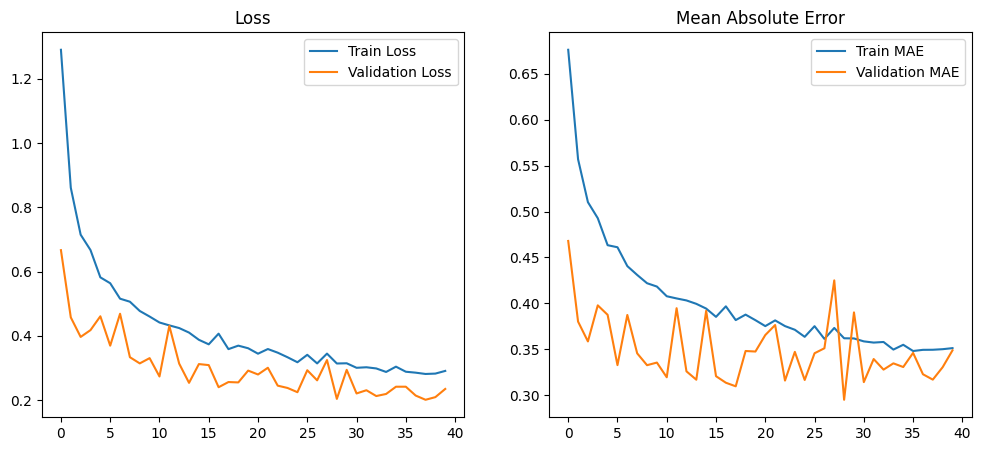

234/234 [==============================] - 1s 5ms/step
Performance visualization saved as 'model_performance.png'


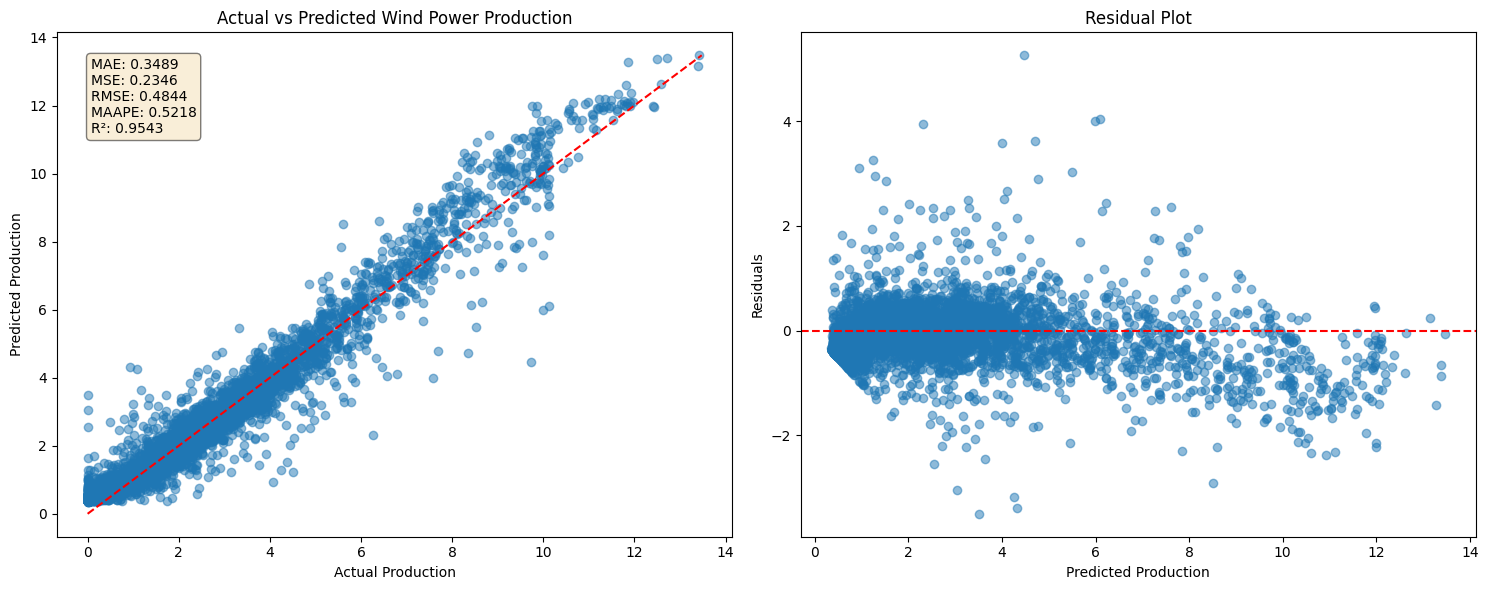

Time series visualization saved as 'wind_power_time_series.png'


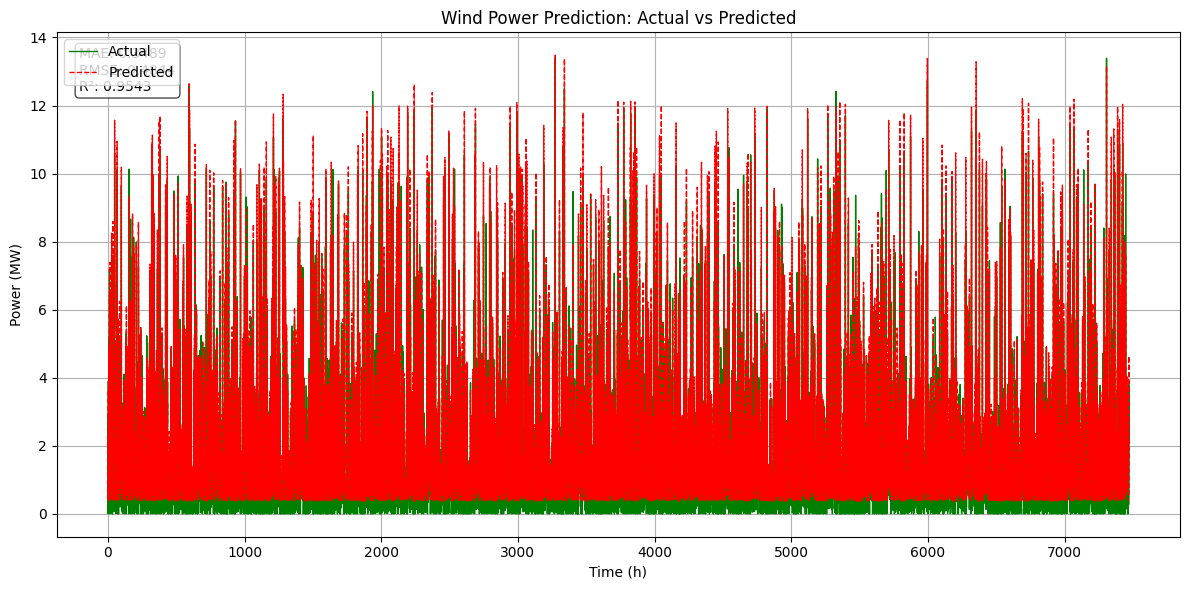


Model Performance Metrics:
MAE (Mean Absolute Error): 0.3489
MSE (Mean Square Error): 0.2346
RMSE (Root Mean Square Error): 0.4844
MAAPE (Mean Arctangent Absolute Percentage Error): 0.5218
R² (Coefficient of Determination): 0.9543
Model training complete. Predictions saved to wind_power_predictions.csv


In [8]:
model, submission, history, X1_val, X2_val, y_val = train_forecasting_model(
        merged_train, merged_test, y_train,
        seq_length=2,
        forecast_horizon=2
    )

# Visualize training history
visualize_training_history(history)

# Visualize predictions vs actual values
visualize_actual_vs_predicted(model, X1_val, X2_val, y_val)

# Save predictions
submission.to_csv('wind_power_predictions.csv', index=False)

print("Model training complete. Predictions saved to wind_power_predictions.csv")

In [9]:
model.save('wind_power_forecasting_model.h5')
print("Model saved as 'wind_power_forecasting_model.h5'")

Model saved as 'wind_power_forecasting_model.h5'


c:\Users\AI-Team\anaconda3\envs\tf_env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings('ignore')

# Load data
x_test = pd.read_csv(r"C:\Users\AI-Team\Documents\wind\DATA\X_test_v2.csv")
wind_farm_data = pd.read_csv(
    r"C:\Users\AI-Team\Documents\wind\DATA\Complementary_data_20200108\WindFarms_complementary_data.csv",
    sep=";",
    engine="python",
    encoding="ISO-8859-1"
)
# Dummy y_train for prepare_sequence_data (since we only need test predictions)
y_train_dummy = pd.DataFrame({'ID': [], 'Production': []})  # Empty DataFrame

# Fix time columns
x_test = fix_time_column(x_test)
wind_farm_data = fix_time_column(wind_farm_data, time_col="Time (UTC)")

# Rename wind farm data columns
wind_farm_data = wind_farm_data.rename(columns={
    'Time (UTC)': 'Time',
    'Wind Farm': 'WF',
    'Average power output (MW)': 'Power',
    'Wind direction (°)': 'WindDir',
    'Wind speed (m/s)': 'WindSpeed',
    'Nacelle direction (°)': 'NacelleDir',
    'Rotational speed (s-1)': 'RotSpeed'
})

# Add WF column to x_test if it doesn't exist
if 'WF' not in x_test.columns:
    # Option 1: Extract from ID (assuming IDs contain wind farm info like "WF1_20200101")
    x_test['WF'] = x_test['ID'].str.extract(r'(WF\d+|[A-Za-z]+\d*)').fillna('Unknown')
    # Option 2: If no WF info, use default
    if x_test['WF'].isna().all():
        unique_wfs = wind_farm_data['WF'].unique()
        default_wf = unique_wfs[0] if len(unique_wfs) > 0 else 'WF1'
        x_test['WF'] = default_wf

# Merge with wind farm data
wind_farm_agg = wind_farm_data.groupby(['Time', 'WF']).agg({
    'Power': 'mean',
    'WindDir': 'mean',
    'WindSpeed': 'mean',
    'NacelleDir': 'mean',
    'RotSpeed': 'mean'
}).reset_index()

merged_test = pd.merge(x_test, wind_farm_agg, on=['Time', 'WF'], how='left')

# Handle missing values
merged_test = handle_missing_values(merged_test)

# Engineer features
merged_test = engineer_features(merged_test)

# Save WF column before one-hot encoding
merged_test_wf = merged_test['WF'].copy()

# One-hot encode categorical features
merged_test = pd.get_dummies(merged_test, columns=['WF'], drop_first=False)

# Add back the original WF column
merged_test['WF'] = merged_test_wf

# Load dummy training data for scaling (to match training preprocessing)
x_train = pd.read_csv(r"C:\Users\AI-Team\Documents\wind\DATA\X_train_v2 (1).csv")
x_train = fix_time_column(x_train)
if 'WF' not in x_train.columns:
    x_train['WF'] = x_train['ID'].str.extract(r'(WF\d+|[A-Za-z]+\d*)').fillna('Unknown')
merged_train = pd.merge(x_train, wind_farm_agg, on=['Time', 'WF'], how='left')
merged_train = handle_missing_values(merged_train)
merged_train = engineer_features(merged_train)
merged_train_wf = merged_train['WF'].copy()
merged_train = pd.get_dummies(merged_train, columns=['WF'], drop_first=False)
merged_train['WF'] = merged_train_wf

# Prepare sequence data
X1_train, X2_train, y_train, X1_test, X2_test, test_ids = prepare_sequence_data(
    merged_train, merged_test, y_train_dummy,
    seq_length=2,
    forecast_horizon=2
)

# Load the saved model
try:
    model = load_model('wind_power_forecasting_model.h5')
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    raise

# Make predictions on test data
try:
    test_predictions = model.predict([X1_test, X2_test])
    print("Predictions generated successfully.")
except Exception as e:
    print(f"Error during prediction: {e}")
    raise

# Create submission DataFrame
submission = pd.DataFrame({
    'ID': test_ids,
    'Production': test_predictions.flatten()
})

# Save predictions
submission.to_csv('test_wind_power_predictions.csv', index=False)
print("Test predictions saved to 'test_wind_power_predictions.csv'")

# Optional: Print sample predictions
print("\nSample predictions (first 5 rows):")
print(submission.head())

Columns in train_df: ['ID', 'Time', 'NWP1_00h_D-2_U', 'NWP1_00h_D-2_V', 'NWP1_00h_D-2_T', 'NWP1_06h_D-2_U', 'NWP1_06h_D-2_V', 'NWP1_06h_D-2_T', 'NWP1_12h_D-2_U', 'NWP1_12h_D-2_V', 'NWP1_12h_D-2_T', 'NWP1_18h_D-2_U', 'NWP1_18h_D-2_V', 'NWP1_18h_D-2_T', 'NWP1_00h_D-1_U', 'NWP1_00h_D-1_V', 'NWP1_00h_D-1_T', 'NWP1_06h_D-1_U', 'NWP1_06h_D-1_V', 'NWP1_06h_D-1_T', 'NWP1_12h_D-1_U', 'NWP1_12h_D-1_V', 'NWP1_12h_D-1_T', 'NWP1_18h_D-1_U', 'NWP1_18h_D-1_V', 'NWP1_18h_D-1_T', 'NWP1_00h_D_U', 'NWP1_00h_D_V', 'NWP1_00h_D_T', 'NWP1_06h_D_U', 'NWP1_06h_D_V', 'NWP1_06h_D_T', 'NWP1_12h_D_U', 'NWP1_12h_D_V', 'NWP1_12h_D_T', 'NWP1_18h_D_U', 'NWP1_18h_D_V', 'NWP1_18h_D_T', 'NWP2_00h_D-2_U', 'NWP2_00h_D-2_V', 'NWP2_12h_D-2_U', 'NWP2_12h_D-2_V', 'NWP2_00h_D-1_U', 'NWP2_00h_D-1_V', 'NWP2_12h_D-1_U', 'NWP2_12h_D-1_V', 'NWP2_00h_D_U', 'NWP2_00h_D_V', 'NWP2_12h_D_U', 'NWP2_12h_D_V', 'NWP3_00h_D-2_U', 'NWP3_00h_D-2_V', 'NWP3_00h_D-2_T', 'NWP3_06h_D-2_U', 'NWP3_06h_D-2_V', 'NWP3_06h_D-2_T', 'NWP3_12h_D-2_U', 'NWP3_